In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Sequential

2025-02-19 04:16:41.235753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define input shape
IMAGE_SIZE = 224 
BATCH_SIZE = 32
#INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)  # 3 for RGB
NUM_CLASSES = 2  # Leukemia vs Normal

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3971 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['healthy blood smear', 'leukemia blood smear']

2025-02-19 04:16:56.304267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


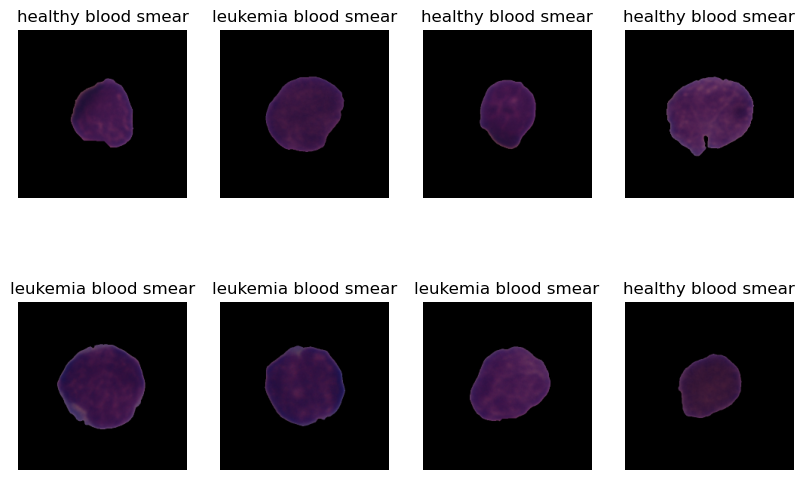

In [5]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_partition_dataset_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_partition_dataset_tf(dataset)

In [8]:
#caching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
# Resizing and rescaling (Normalization)
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize images
    layers.Rescaling(1.0 / 255)  # Normalize pixel values (0-1)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip images randomly
    layers.RandomRotation(0.3),  # Rotate up to 30% of the image
    #layers.RandomZoom(0.3),  # Zoom in/out up to 30%
    #layers.RandomContrast(0.3),  # Adjust contrast to simulate lighting conditions
    #layers.RandomBrightness(0.2),  # Brightness variations
    #layers.RandomTranslation(0.2, 0.2),  # Shift images in x and y directions  # Skew the image slightly
])



2025-02-19 04:17:16.855939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 98 of 10000
2025-02-19 04:17:20.138936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-02-19 04:17:20.231855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..109.43744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..120.09233].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..108.211555].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..110.87767].
Clipping input data to the valid range for imshow with RGB d

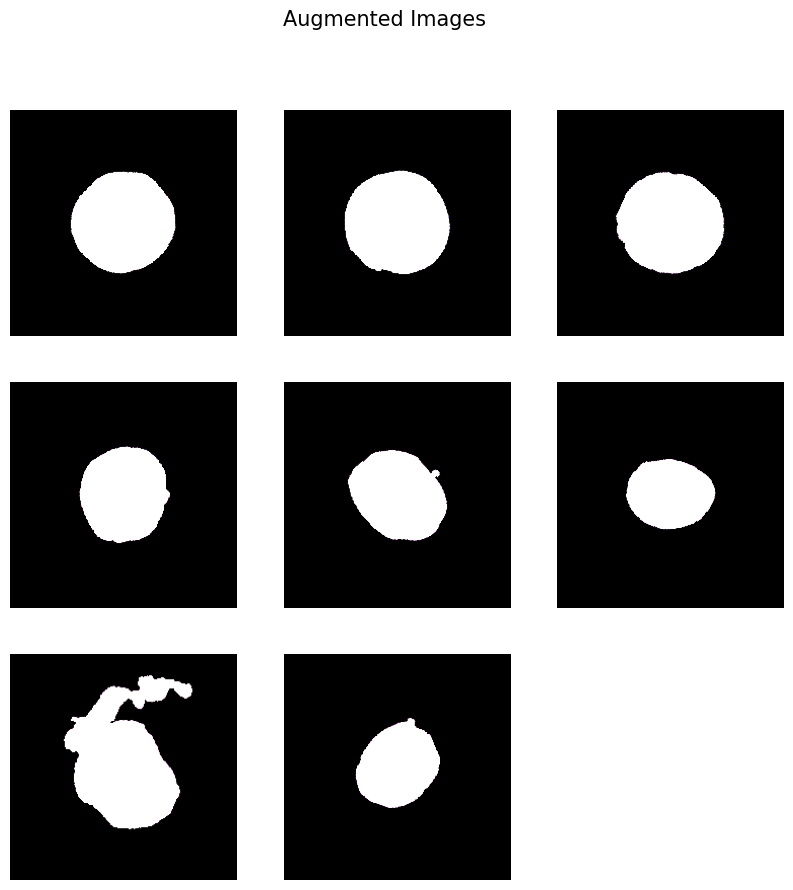

In [10]:
image_batch, label_batch = next(iter(train_ds))

# Apply augmentation to a batch of images
augmented_images = data_augmentation(image_batch)

# Plot the original and augmented images side by side
plt.figure(figsize=(10, 10))
for i in range(8):  # Show 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy())  # Convert tensor to numpy
    plt.axis("off")
plt.suptitle("Augmented Images", fontsize=15)
plt.show()

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(NUM_CLASSES, activation = 'softmax')
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))  # Batch size can be None
model.summary()

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,770 (909.26 KB)

 Trainable params: 232,770 (909.26 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [13]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose = 1, 
    validation_data = val_ds
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7083 - loss: 0.5732

2025-02-19 04:22:12.918321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 111 of 10000
2025-02-19 04:22:14.319619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-02-19 04:22:14.808328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.7089 - loss: 0.5727 - val_accuracy: 0.8177 - val_loss: 0.4504
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - accuracy: 0.7924 - loss: 0.4769 - val_accuracy: 0.8099 - val_loss: 0.4497
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.7780 - loss: 0.4903 - val_accuracy: 0.8073 - val_loss: 0.4634
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 454s 5s/step - accuracy: 0.7969 - loss: 0.4736 - val_accuracy: 0.8125 - val_loss: 0.4482
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.7810 - loss: 0.4977 - val_accuracy: 0.8255 - val_loss: 0.4267
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.7958 - loss: 0.4762 - val_accuracy: 0.8333 - val_loss: 0.4188
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.8022 - loss: 0.4680 - val_accuracy: 0.8151 - val_loss: 0.4261
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.8066 - loss: 0.4510 - val_accuracy: 0.833

In [14]:
scores = model.evaluate(test_ds)

2025-02-19 13:13:42.506286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 112 of 10000
2025-02-19 13:13:43.315541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-02-19 13:13:43.737853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 589ms/step - accuracy: 0.9094 - loss: 0.2090


In [17]:
model.export("./saved_model/1")

INFO:tensorflow:Assets written to: ./saved_model/1/assets


INFO:tensorflow:Assets written to: ./saved_model/1/assets


Saved artifact at './saved_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140594964694288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594965749424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140592616246256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140592616246960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140592616261760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140592616261408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140592616284576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140592616284224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140592616286864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140592616286512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1405926162973

In [40]:
model.save("leukemia_new.h5")

In [41]:
model.export("./saved_model")

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


Saved artifact at './saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_41')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140148442871232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148442870176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148504465248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148504478464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148504479872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148504479520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148504498592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148504498240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148504500880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140148504500528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14014850451140

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Standard TFLite ops
    tf.lite.OpsSet.SELECT_TF_OPS      # Enable TF ops fallback
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the TFLite model
with open("model_quant.tflite", "wb") as f:
    f.write(tflite_model)


In [78]:
len(tflite_quant_model)

215560

In [79]:
import tensorflow.lite as tflite

interpreter = tflite.Interpreter(model_path="model_quant.tflite")
interpreter.allocate_tensors()

print("Model loaded successfully!")


Model loaded successfully!


INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 6 nodes delegated out of 94 nodes with 3 partitions.

2025-02-12 18:58:26.341750: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_inter_op_parallelism which is not in the op definition: Op<name=StatelessRandomGetKeyCounter; signature=seed:Tseed -> key:uint64, counter:uint64; attr=Tseed:type,default=DT_INT64,allowed=[DT_INT32, DT_INT64]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node StatelessRandomGetKeyCounter}}
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
plt.plot(range(10), acc, label = 'Training Accuracy')
plt.plot(range(10), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(10), loss, label = 'Training Loss')
plt.plot(range(10), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Loss")

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n predicted_class = {predicted_class} \n Confidence = {confidence}%")
        plt.axis("off")

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [ ]:
pip install --upgrade tensorflow

In [ ]:
from tensorflow import keras
model.save('leukemia_model.keras')  # Save in the new Keras 3 format


In [ ]:
import tensorflow as tf

# Load the .keras model
model = tf.keras.models.load_model('leukemiaModel.keras')
# Initialize the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Set optimization options (e.g., for size or latency)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
    

In [ ]:
import tensorflow as tf

# Define the input signature
input_shape = (32, 256, 256, 3)  # Batch size of 32, 256x256 RGB images
input_signature = [tf.TensorSpec(shape=input_shape, dtype=tf.float32)]

In [ ]:
tf.keras.models.save_model(model, "modelLL.keras")


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Assuming your test dataset is named 'test_dataset'
y_true = []
y_pred_prob = []

for images, labels in test_ds:
    preds = model.predict(images)  # Get predicted probabilities
    y_pred_prob.extend(preds)      # Store probabilities
    y_true.extend(labels.numpy())  # Store true labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

In [ ]:
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)


In [ ]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'macro' for equal class weighting

# Recall
recall = recall_score(y_true, y_pred, average='weighted')

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')

# AUC-ROC (only for binary classification)
if len(np.unique(y_true)) == 2:
    auc_roc = roc_auc_score(y_true, y_pred_prob)
else:
    auc_roc = "Not applicable for multi-class"

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc}")


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Collect true labels and predicted probabilities
y_true = []
y_pred_prob = []

for images, labels in test_ds:
    preds = model.predict(images)  # Get predicted probabilities
    y_pred_prob.extend(preds)      # Store probabilities
    y_true.extend(labels.numpy())  # Store true labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Fix mismatch issue
if len(y_true.shape) > 1:  
    y_true = np.argmax(y_true, axis=1)  # Convert one-hot to class labels

if y_pred_prob.shape[-1] > 1:  
    y_pred = np.argmax(y_pred_prob, axis=1)  # Multi-class classification
else:
    y_pred = (y_pred_prob > 0.5).astype(int)  # Binary classification

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
auc_roc = roc_auc_score(y_true, y_pred_prob[:, 1]) if y_pred_prob.shape[-1] > 1 else roc_auc_score(y_true, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
